In [1]:
import torch
from transformers import *

In [2]:
import numpy as np
import pandas as pd

STORY = "pieman"

token_stimulus_df = pd.read_csv("data/stimuli/{}/tr_tokens.csv".format(STORY))
token_stimulus_df.n_tokens = token_stimulus_df.n_tokens.fillna(0)
token_stimulus_df.tokens = token_stimulus_df.tokens.fillna("")

In [3]:
token_stimulus_df.head()

tr   start_ts     end_ts  tr.1                   tokens  n_tokens  \
0  10  15.089999  16.310000    10   I began my illustrious       4.0   
1  11  16.330000  17.929999    11     career in journalism       3.0   
2  12  18.469999  19.390000    12       in the Bronx where       4.0   
3  13  19.390000  20.890000    13       I toiled as a hard       5.0   
4  14  20.890000  22.360000    14  boiled reporter for the       4.0   

   tr_shift  prev_tr  
0       NaN      NaN  
1       1.0     10.0  
2       1.0     11.0  
3       1.0     12.0  
4       1.0     13.0

### Stimulus Analysis
Quick checks: how many words do we have per TR?  
Use this to determine parameters for attention head analysis.

In [4]:
token_stimulus_df.n_tokens.describe()

count    277.000000
mean       3.454874
std        2.127022
min        0.000000
25%        2.000000
50%        3.000000
75%        5.000000
max       12.000000
Name: n_tokens, dtype: float64

In [5]:
token_stimulus_df.n_tokens.value_counts().sort_index()

0.0     23
1.0     23
2.0     48
3.0     59
4.0     44
5.0     41
6.0     18
7.0      4
8.0     12
9.0      4
12.0     1
Name: n_tokens, dtype: int64

# RSMs from GPT2

#### Set up GPT2 model

In [6]:
gpt2_weights = 'gpt2'
gpt2_tokenizer = GPT2Tokenizer.from_pretrained(gpt2_weights)

# Models can return full list of hidden-states & attentions weights at each layer
gpt2 = GPT2Model.from_pretrained(gpt2_weights,
                                 output_hidden_states=True,
                                 output_attentions=True)
if torch.cuda.is_available():
    gpt2.to('cuda')
gpt2.eval()

Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0): Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (c_fc): Conv1D

In [7]:
def stimulus_to_rsm_dataframe(stimulus, tr_lookback_window):

    # Set this inside the loop based on whichever GPT2 model we're using
    num_gpt2_layers = 0;

    tr_activation_array = {}
    for i, tr in enumerate(stimulus):
        if i%50==0:
            print(i)
        # Get the whole window we're going to 
        window_start = max(0, i - tr_lookback_window)
        window_stimulus = " ".join(stimulus[window_start:i+1])
        if torch.cuda.is_available():
            window_tokens = torch.cuda.LongTensor([gpt2_tokenizer.encode(window_stimulus, add_special_tokens=True)])
            tr_tokens = torch.cuda.LongTensor([gpt2_tokenizer.encode(tr, add_special_tokens=False)])[0]
        else:
            window_tokens = torch.tensor([gpt2_tokenizer.encode(window_stimulus, add_special_tokens=True)])
            tr_tokens = torch.tensor([gpt2_tokenizer.encode(tr, add_special_tokens=False)])[0]
        if window_tokens.shape[1] == 0:
            continue
        with torch.no_grad():

            tr_activation_array[i] = {}
            gpt2_states, gpt2_attentions = gpt2(window_tokens)[-2:]
            
            num_gpt2_layers = len(gpt2_states)

            for l, layer in enumerate(gpt2_states):
                
                if len(tr_tokens) > 0:
                    # ASSUMPTION: we do not want to include the CLS/SEP token in the TR RSM.
                    # If we do, switch indexing here to include last token.
                    #SEP token for GPT2 (<|endoftext|>) is not included in the inputs
                    tr_activations = layer[0][-len(tr_tokens):]
                    
                else:
                    # ASSUMPTION: if we don't have any tokens in this TR, use the last token's representation. --> should we use lasttoken or CLS/SEP?
                    tr_activations = layer[0][-1:]

                # ASSUMPTION: take the mean of all tokens falling inside the TR stimuli window.
                tr_activation_array[i][l] = torch.mean(tr_activations, 0)
    # We now have the layers in a TR-based index: tr_activation_array[tr_index][layer_index]
    # To get a layer-wise RSM, we need to reverse this indexing. 
    layerwise_rsms = []
    for l in range(0, num_gpt2_layers):

        # Loop over our TR array and grab the target layer for each 
        layer_activations = [tr_activation_array[tr][l] for tr in tr_activation_array]
    
        stacked = np.stack([l.cpu().numpy() for l in layer_activations], axis=0)
        rsm_dataframe = pd.DataFrame(np.corrcoef(stacked))
        layerwise_rsms.append(rsm_dataframe)
    
    return layerwise_rsms

## Activation RSMs

Try generating a set of RSMs for a full text.

In [8]:
ANALYSIS_NAME = "all_activations"

In [9]:
stimulus_for_rsm = token_stimulus_df

In [10]:
activation_rsm_dfs = stimulus_to_rsm_dataframe(stimulus_for_rsm.tokens.values, 20)

0
50
100
150
200
250


In [11]:
results_rsm_df = activation_rsm_dfs

In [12]:
for i, df in enumerate(results_rsm_df):
    np_array = df.to_numpy()
    np.save("data/{}/{}/{}/layer_{}_rsm.npy".format(STORY, gpt2_weights,ANALYSIS_NAME, i),np_array)

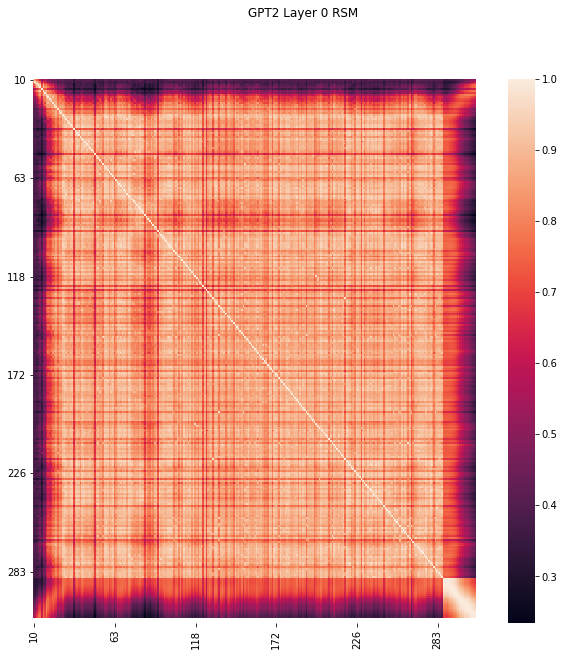

In [13]:
import matplotlib.pylab as plt
import seaborn as sns

plt.figure(figsize=(10,10))
ax = sns.heatmap(results_rsm_df[0], xticklabels=stimulus_for_rsm.tr, yticklabels=stimulus_for_rsm.tr)

ax.set_xticks(ax.get_xticks()[::50])
ax.set_yticks(ax.get_yticks()[::50])
plt.suptitle("GPT2 Layer 0 RSM");

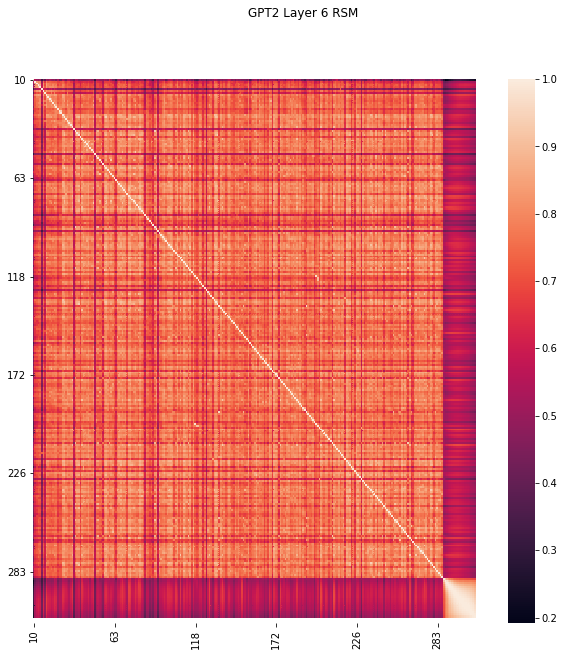

In [14]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(results_rsm_df[5], xticklabels=stimulus_for_rsm.tr, yticklabels=stimulus_for_rsm.tr)

ax.set_xticks(ax.get_xticks()[::50])
ax.set_yticks(ax.get_yticks()[::50])

plt.suptitle("GPT2 Layer 6 RSM");

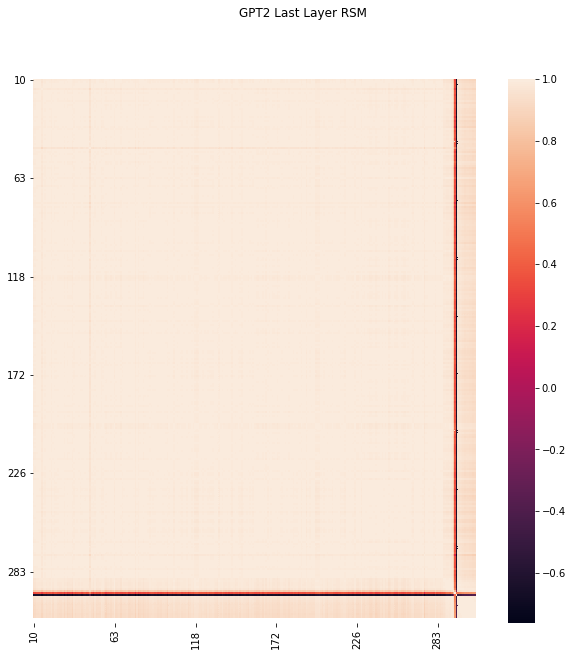

In [15]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(results_rsm_df[-1], xticklabels=stimulus_for_rsm.tr, yticklabels=stimulus_for_rsm.tr)

ax.set_xticks(ax.get_xticks()[::50])
ax.set_yticks(ax.get_yticks()[::50])

plt.suptitle("GPT2 Last Layer RSM");

# Attention RSMs

In [16]:
ANALYSIS_NAME = "all_attentions"

In [19]:
def stimulus_to_attention_rsm_dataframe(stimulus, tr_lookback_window, num_window_tokens=10, num_tr_tokens=6, verbose=False):
    """Return window_tokens x tr_tokens x num_heads attention matrix"""

    # Set this inside the loop based on whichever GPT2 model we're using
    num_gpt2_layers = 0;

    tr_activation_array = {}
    for i, tr in enumerate(stimulus):
        if i%50==0:
            print(i)
        # Get all of the stimulus for the TR lookback window (e.g. words for last X seconds) 
        window_start = max(0, i - tr_lookback_window)
        window_stimulus = " ".join(stimulus[window_start:i+1])
        
        # Get the list of GPT2 tokens involved in that window
        window_tokens = gpt2_tokenizer.encode_plus(window_stimulus, return_tensors='pt', add_special_tokens=True)
        
        # window_token_ids is now a tensor containing *all* of the tokens in this TR stimulus window.
        # We need to filter it down to our fixed dimensionality, window_tokens
        window_token_ids = window_tokens['input_ids']
    
        if len(window_token_ids[0]) < num_window_tokens:
            # We don't have enough words yet. This is typical for the first few TRs-- we need to build up context.
            if verbose:
                print("TR {}: not enough tokens ({}/{})".format(i, len(window_token_ids[0]), num_window_tokens))
            continue

        truncated_window_token_ids = window_token_ids[0][-num_window_tokens:]
        if verbose:
            print("TR {}: more than enough tokens ({}/{}), trimmed to {}.".format(i, len(window_token_ids[0]), num_window_tokens, len(truncated_window_token_ids)))
    
        with torch.no_grad():

            tr_activation_array[i] = {}
            _, gpt2_attentions = gpt2(truncated_window_token_ids.reshape(1, -1))[-2:]
            num_gpt2_layers = len(gpt2_attentions)

            # gpt2_attentions is now a tuple of length n_layers
            # Each element of the tuple contains the outputs of each attention head in that layer.
            # So, for example, gpt2_attentions[0] will be of torch.Size([1, n_heads, num_window_tokens, num_window_tokens])
            # Running this on gpt2-large with num_window_tokens = 40 will yield:
            # len(gpt2_attentions) = 12 --> 12 layers in the model
            # gpt2_attentions[0].shape = torch.Size([1, 12, 40, 40]) --> 12 attention heads, 40x40 attention weights
            if verbose:
                print("Extracting heads from {} layers, each of shape {}.".format(num_gpt2_layers, gpt2_attentions[0].shape))
            
            for l, layer in enumerate(gpt2_attentions):
                                
                # Need to flatten our attentions to 1D vector.
                # This is complicated but basically collapses all attention heads down to a single vector
                # which will have length = n_heads * n_window_tokens * n_window_tokens 
                tr_activations = layer[0].reshape(1,-1)[0]

                tr_activation_array[i][l] = tr_activations

    # We now have the layers in a TR-based index: tr_activation_array[tr_index][layer_index]
    # To get a layer-wise RSM, we need to reverse this indexing. 
    layerwise_rsms = []
    for l in range(0, num_gpt2_layers):

        # Loop over our TR array and grab the target layer for each 
        layer_activations = [tr_activation_array[tr][l] for tr in tr_activation_array]
    
        stacked = np.stack([l.numpy() for l in layer_activations], axis=0)
            
        rsm_dataframe = pd.DataFrame(np.corrcoef(stacked))

        layerwise_rsms.append(rsm_dataframe)
    
    return layerwise_rsms

In [20]:
gpt2.to('cpu')
attention_rsm_dfs = stimulus_to_attention_rsm_dataframe(stimulus_for_rsm.tokens.values, 10)

0
50
100
150
200
250


In [21]:
for i, df in enumerate(attention_rsm_dfs):
    np_array = df.to_numpy()
    np.save("data/{}/{}/{}/layer_{}_rsm.npy".format(STORY, gpt2_weights, ANALYSIS_NAME, i), np_array)

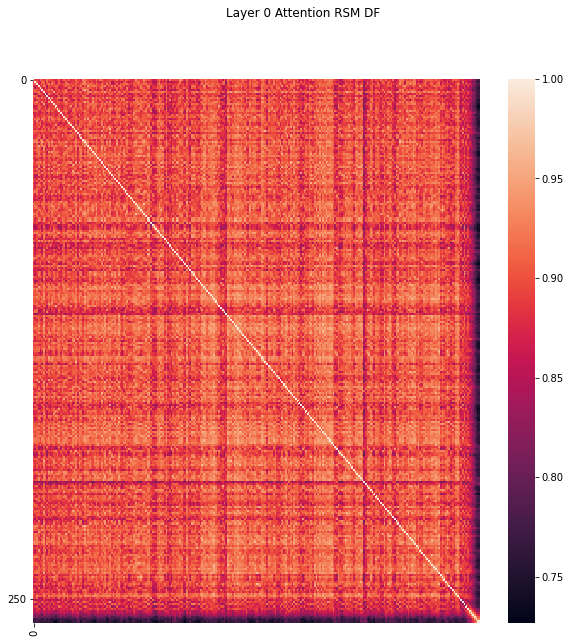

In [22]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(attention_rsm_dfs[0])

ax.set_xticks(ax.get_xticks()[::50])
ax.set_yticks(ax.get_yticks()[::50])

plt.suptitle("Layer 0 Attention RSM DF");

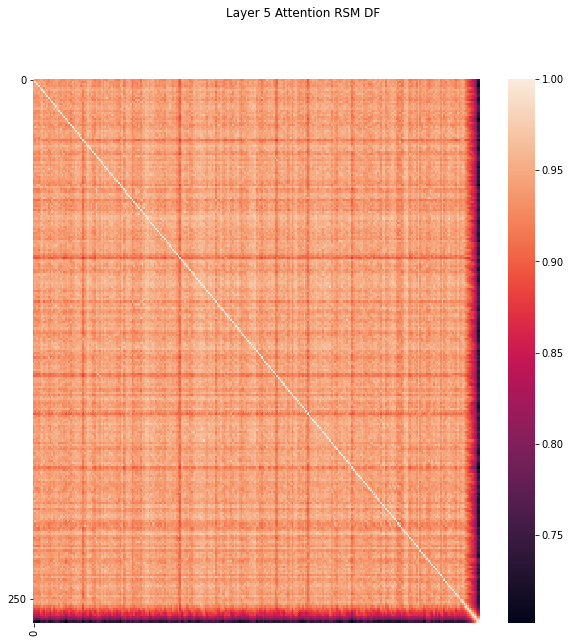

In [23]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(attention_rsm_dfs[5])

ax.set_xticks(ax.get_xticks()[::50])
ax.set_yticks(ax.get_yticks()[::50])

plt.suptitle("Layer 5 Attention RSM DF");

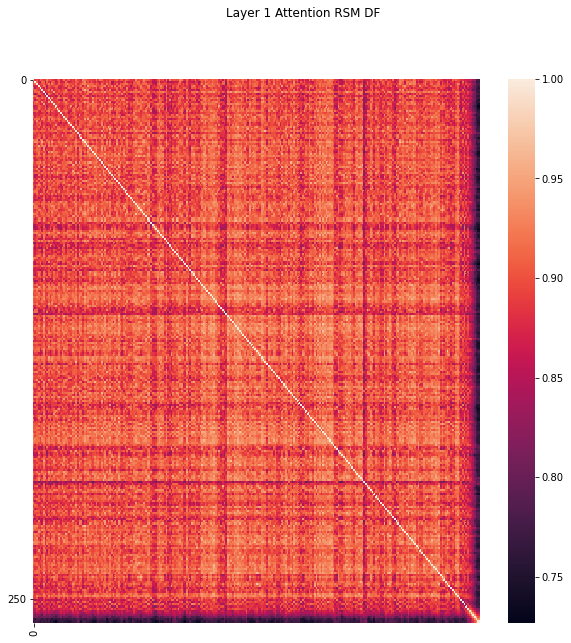

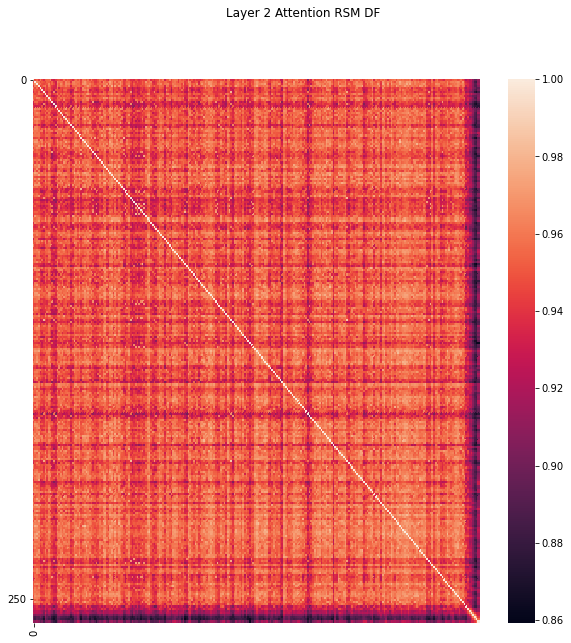

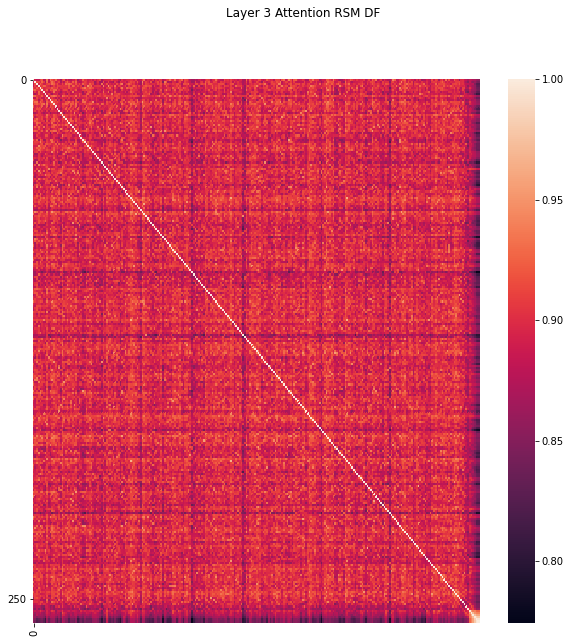

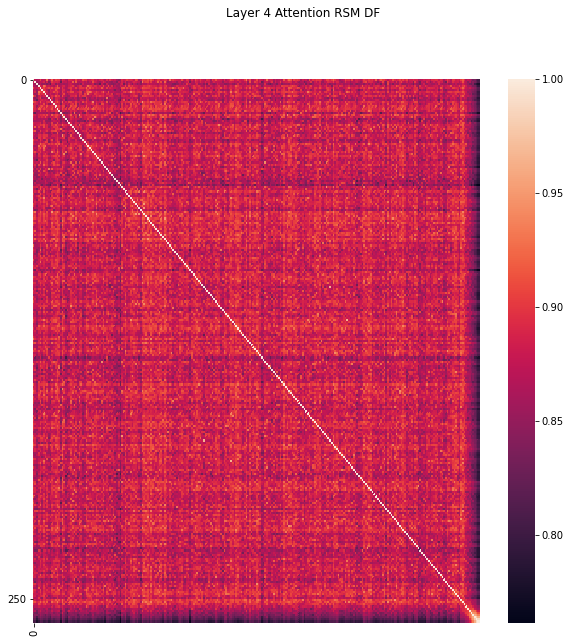

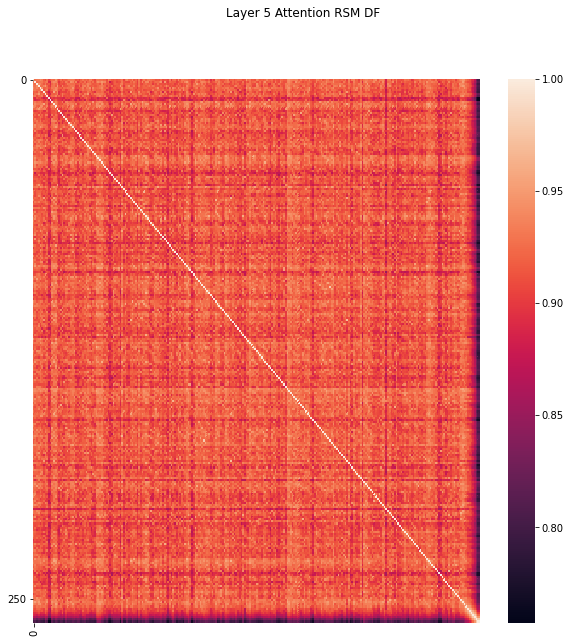

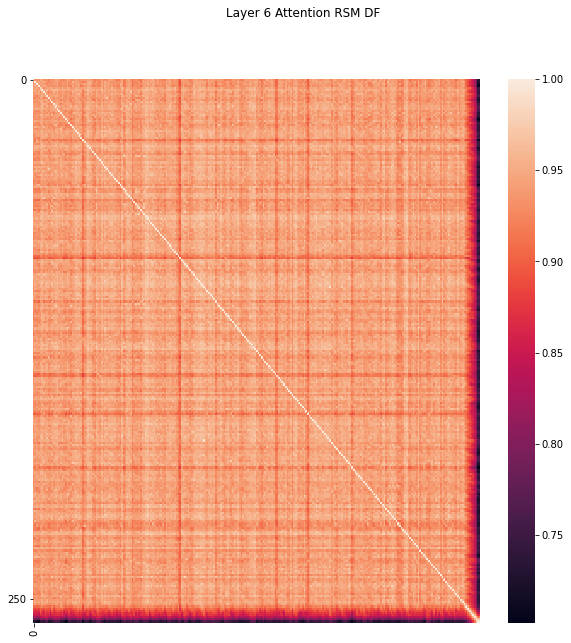

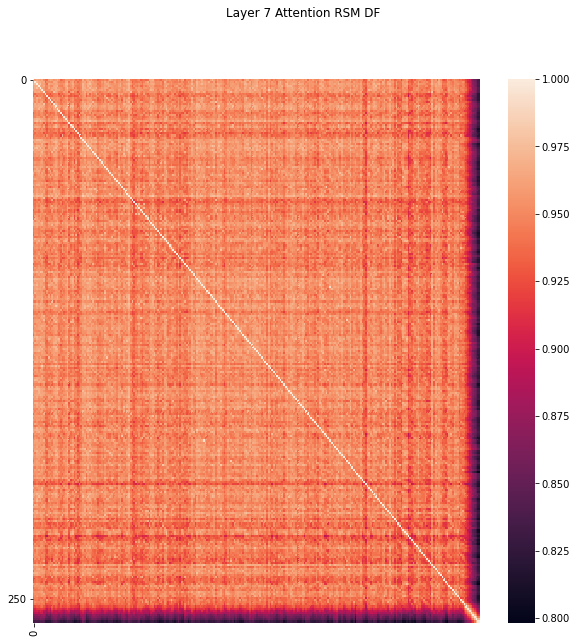

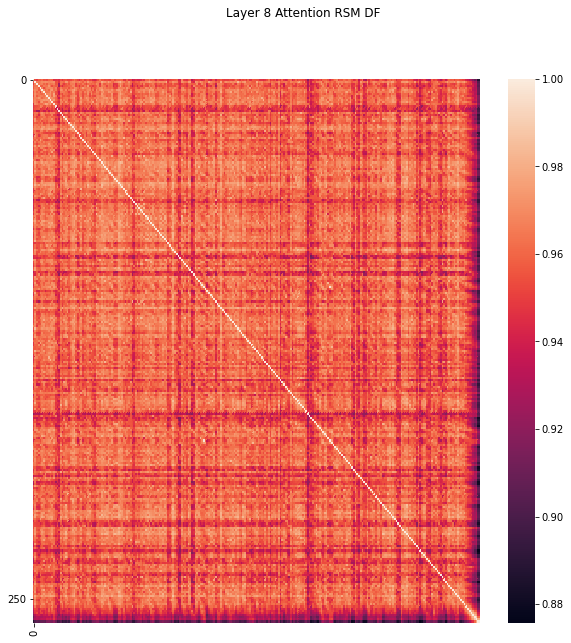

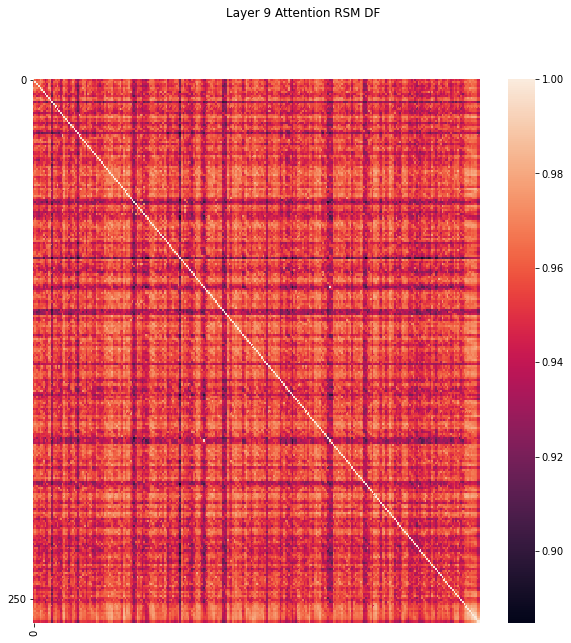

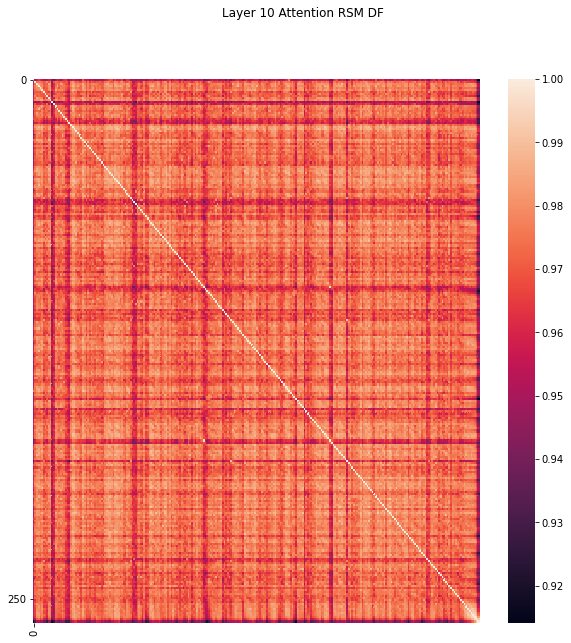

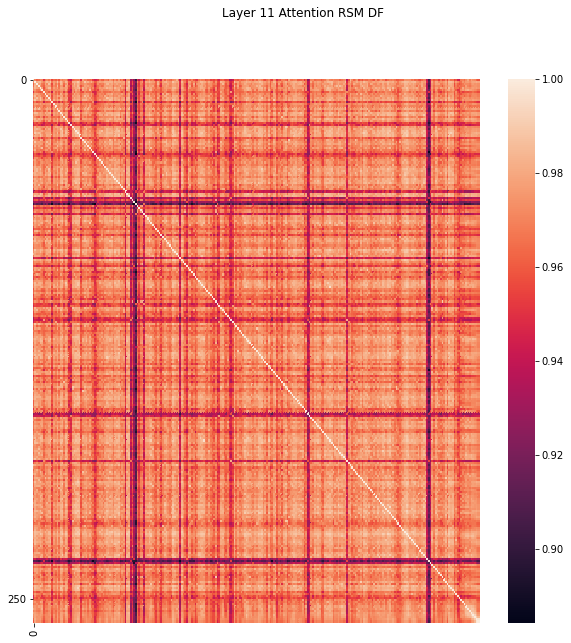

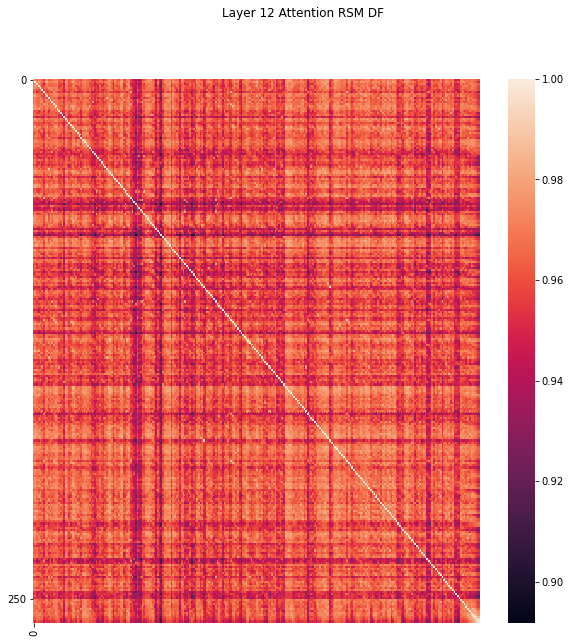

In [24]:
for layer in range(0, len(attention_rsm_dfs)):
    
    plt.figure(figsize=(10,10))
    ax = sns.heatmap(attention_rsm_dfs[layer])

    ax.set_xticks(ax.get_xticks()[::50])
    ax.set_yticks(ax.get_yticks()[::50])

    plt.suptitle("Layer {} Attention RSM DF".format(layer+1));
    plt.show();